# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

In [4]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

**Training Data**

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/disaster_nlp/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
print('Rows and columns in training set: ', train_df.shape)

Rows and columns in training set:  (7613, 5)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


# **Exploratory Data Analysis**

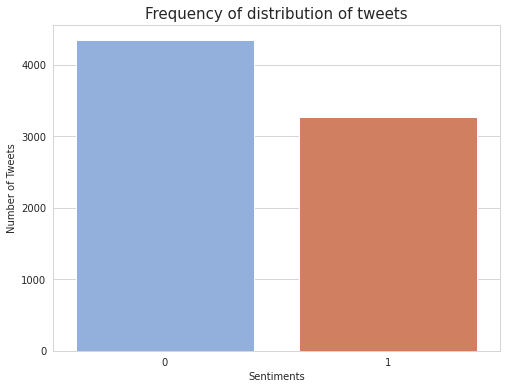

In [11]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize = (8, 6))
colors = ['#87ace8', '#e3784d']
ax = sns.countplot(x = 'target', data = train_df, palette = colors)
plt.gca().set_ylabel('Number of Tweets')
plt.gca().set_xlabel('Sentiments')
plt.title('Frequency of distribution of tweets', fontsize = 15)
plt.show()

fig = px.pie(train_df, names = 'target', height = 400, width = 400, color_discrete_sequence = colors, title = 'Pie chart for distribution of tweets')
fig.update_traces(textfont_size = 15)
fig.show()

**Keywords in training dataset**

In [12]:
dist_keyword = train_df['keyword'].value_counts()
dist_keyword

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

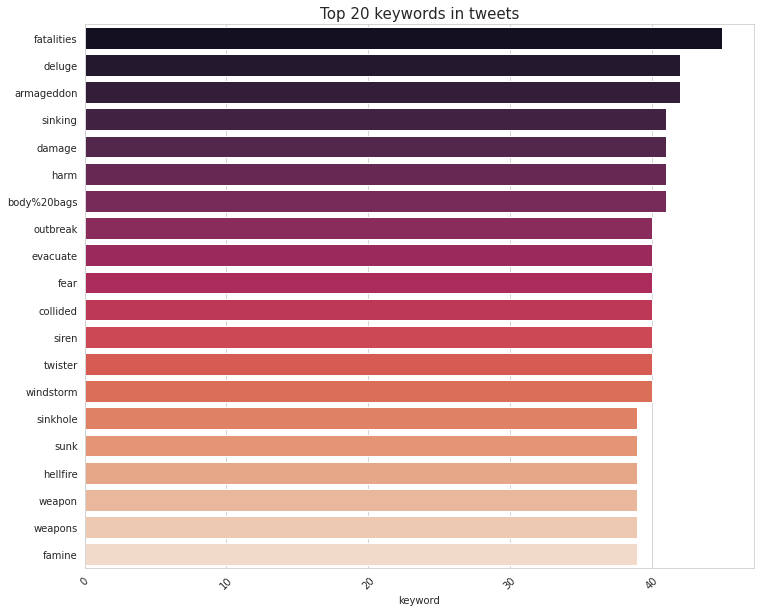

In [13]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize = (12, 10))
top_keywords = train_df['keyword'].value_counts()[:20]
ax = sns.barplot(y = top_keywords.index, x = top_keywords, palette = 'rocket', data = train_df) 
plt.title('Top 20 keywords in tweets', fontsize = 15)
plt.xticks(rotation = 45)
plt.show()

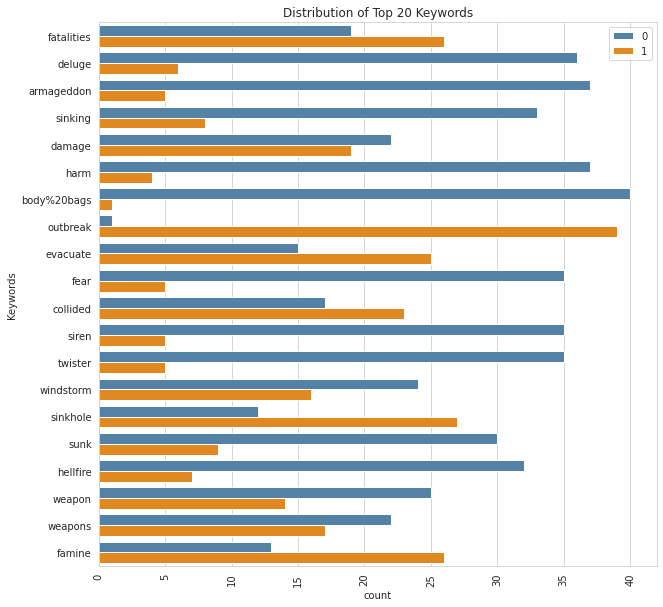

In [14]:
plt.figure(figsize = [10, 10])
sns.countplot(y = 'keyword', data = train_df, order = train_df['keyword'].value_counts()[:20].index, hue = 'target', palette = ['steelblue', 'darkorange']).set(title = 'Distribution of Top 20 Keywords', ylabel = 'Keywords')
plt.xticks(rotation = 90)
plt.legend(loc = 'upper right')
plt.show()

**Plotting Top 20 Disaster and Non-Disaster Keywords**

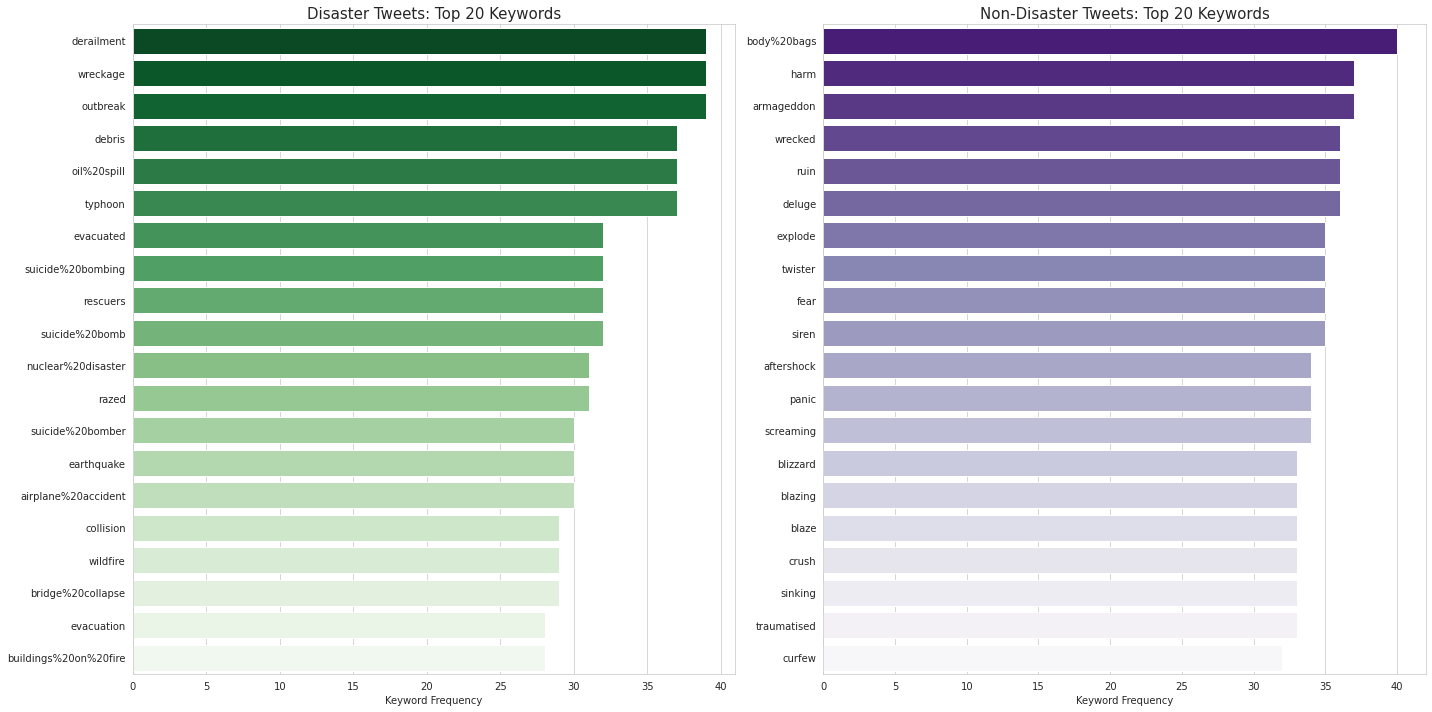

In [39]:
disaster_keywords = train_df.loc[train_df['target'] == 1]['keyword'].value_counts() 
non_disaster_keywords = train_df.loc[train_df['target'] == 0]['keyword'].value_counts()

fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax1 = sns.barplot(y = disaster_keywords[0:20].index, x = disaster_keywords[0:20], orient = 'h', ax = ax[0], palette = 'Greens_r')
ax[0].set_title('Disaster Tweets: Top 20 Keywords', fontsize = 15)
ax[0].set_xlabel('Keyword Frequency')

ax2 = sns.barplot(y = non_disaster_keywords[0:20].index, x = non_disaster_keywords[0:20], orient = 'h', ax = ax[1], palette = 'Purples_r')
ax[1].set_title('Non-Disaster Tweets: Top 20 Keywords', fontsize = 15)
ax[1].set_xlabel('Keyword Frequency')

plt.tight_layout()
plt.show()

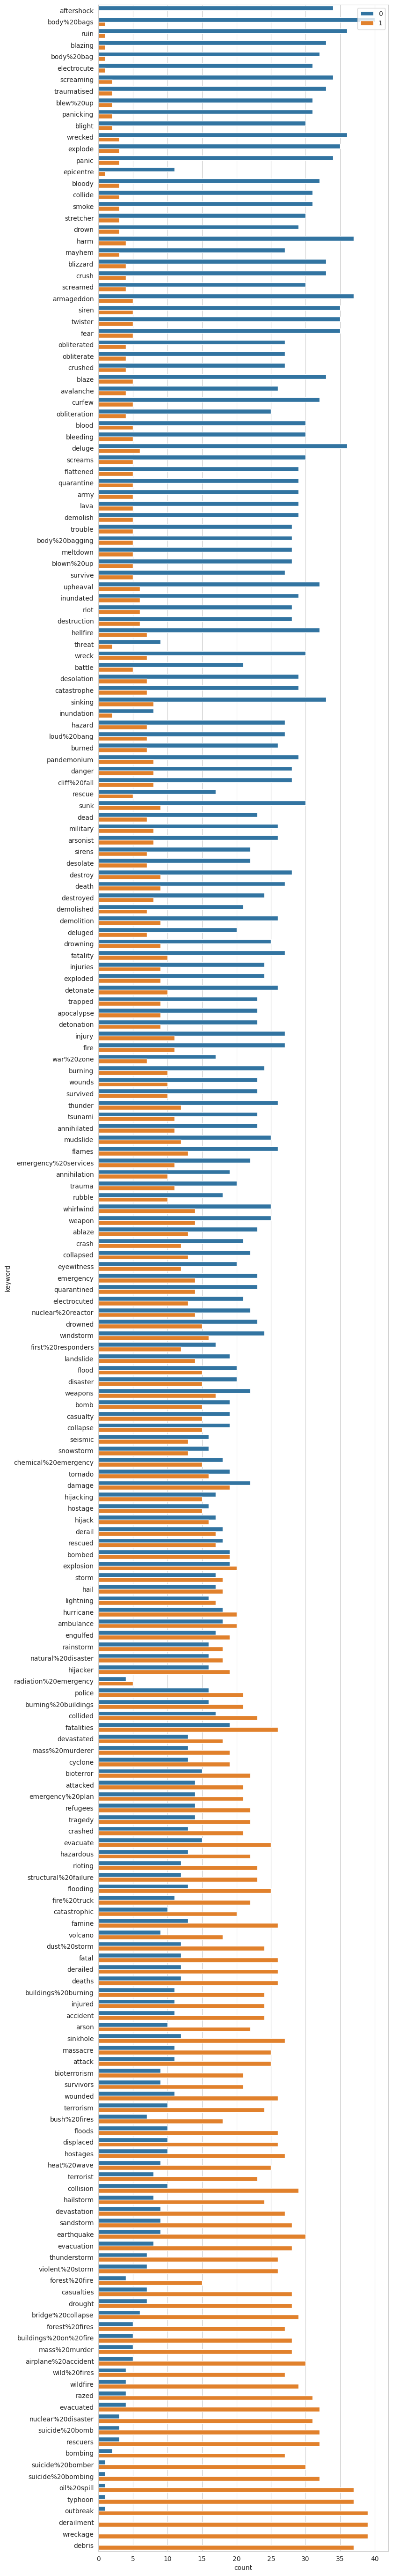

In [40]:
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean') 
plt.figure(figsize = (8, 72), dpi = 100) 
sns.countplot(data = train_df.sort_values(by = 'target_mean'), hue = 'target', y = 'keyword')
plt.legend(loc = 1)

train_df.drop(columns = 'target_mean', inplace = True)

In [41]:
fake_df = train_df[train_df['target'] == 0]
print('Most common keywords for fake tweets')
fake_df['keyword'].value_counts()[:20]

Most common keywords for fake tweets


body%20bags    40
harm           37
armageddon     37
wrecked        36
ruin           36
deluge         36
explode        35
twister        35
fear           35
siren          35
aftershock     34
panic          34
screaming      34
blizzard       33
blazing        33
blaze          33
crush          33
sinking        33
traumatised    33
curfew         32
Name: keyword, dtype: int64

In [42]:
real_df = train_df[train_df['target'] == 1]
print('Most common keywords for real tweets')
real_df['keyword'].value_counts()[:20]

Most common keywords for real tweets


derailment               39
wreckage                 39
outbreak                 39
debris                   37
oil%20spill              37
typhoon                  37
evacuated                32
suicide%20bombing        32
rescuers                 32
suicide%20bomb           32
nuclear%20disaster       31
razed                    31
suicide%20bomber         30
earthquake               30
airplane%20accident      30
collision                29
wildfire                 29
bridge%20collapse        29
evacuation               28
buildings%20on%20fire    28
Name: keyword, dtype: int64

**Tweets Length**

In [43]:
train_df['length'] = train_df['text'].apply(len)
train_df['length']

0        69
1        38
2       133
3        65
4        88
       ... 
7608     83
7609    125
7610     65
7611    137
7612     94
Name: length, Length: 7613, dtype: int64

In [44]:
print('Tweet character length for:', train_df['text'][0], 'is', train_df['length'][0])

Tweet character length for: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all is 69


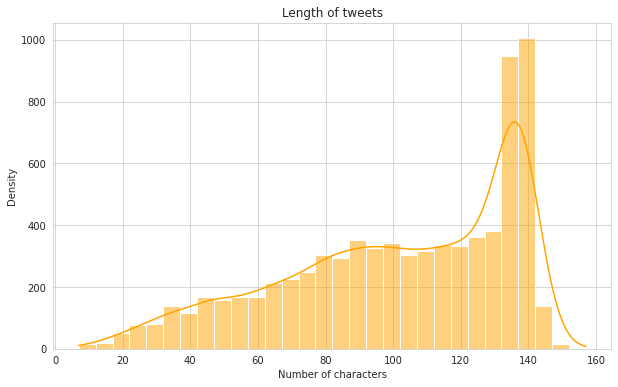

In [45]:
plt.figure(figsize = (10, 6))
sns.histplot(train_df['length'], kde = True, color = 'orange', bins = 30)
plt.title('Length of tweets')
plt.xlabel('Number of characters')
plt.ylabel('Density')
plt.show()

**Tweet length of Disaster/Non-disaster tweets**

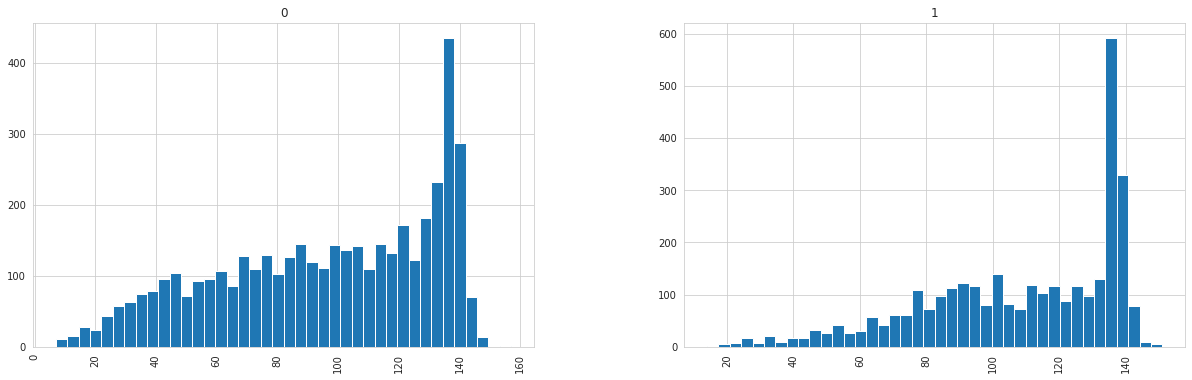

In [46]:
train_df.hist(column = 'length', by = 'target', bins = 40, figsize = (20, 6))
plt.show()

**Top locations from where the tweets were sent**

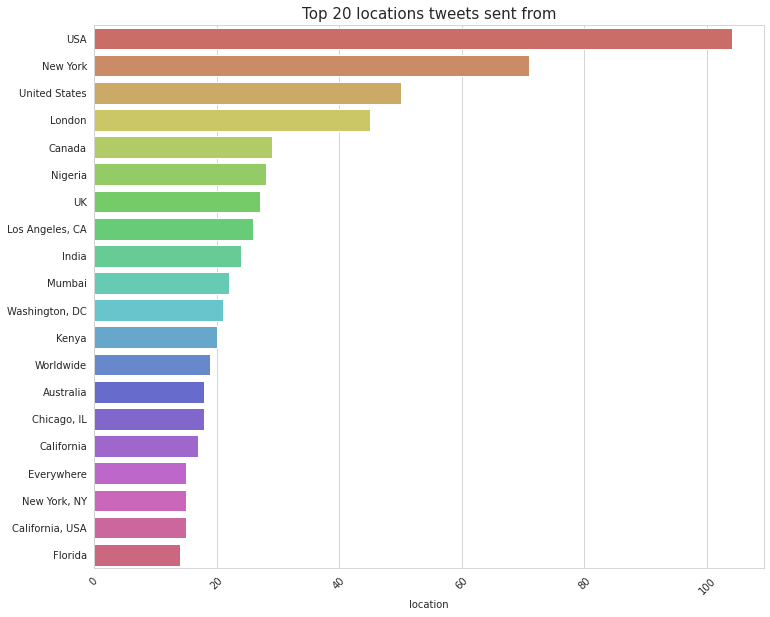

In [47]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize = (12, 10))

locations = train_df['location'].value_counts()
ax = sns.barplot(y = locations[0:20].index, x = locations[0:20], palette = 'hls', data = train_df)

plt.title('Top 20 locations tweets sent from', fontsize = 15)
plt.xticks(rotation = 45)
plt.show()

# **Data Preprocessing**

**Handling null values**

In [48]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

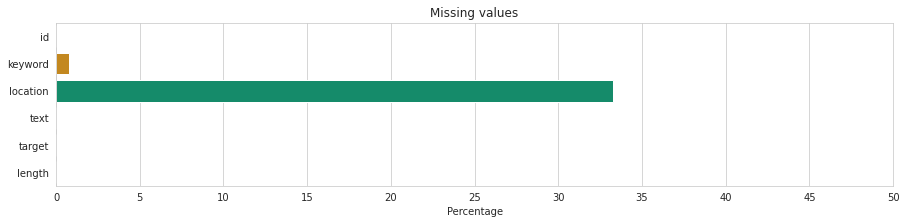

In [49]:
percentage_missing = train_df.isnull().sum() * 100 / len(train_df) 
plt.figure(figsize = (15, 3))
sns.barplot(x = list(percentage_missing), y = list(percentage_missing.index), palette = 'colorblind').set(title = 'Missing values',
                                                                                                          xlabel = 'Percentage', xlim = (0, 50), xticks = range(0, 55, 5))
plt.show()

In [21]:
train_df = train_df.drop(['location'], axis = 1)
train_df = train_df.dropna()

In [22]:
train_df.isna().sum()

id         0
keyword    0
text       0
target     0
length     0
dtype: int64

In [23]:
train_df.head()

,id,keyword,text,target,length
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
34,52,ablaze,Crying out for more! Set me ablaze,0,34
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


In [24]:
train_df.reset_index(inplace = True)

In [25]:
train_df.head()

,index,id,keyword,text,target,length
0,31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
1,32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67
2,33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
3,34,52,ablaze,Crying out for more! Set me ablaze,0,34
4,35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


In [26]:
x = train_df['text']
y = train_df['target']
y.shape

(7552,)

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

result.lower
- By this we are going to replace all the words in Lower case so that all are treated as equally


re.sub()
- Replace with regular expression
- Replace multiple substrings with the same string
- Replace using the matched part
- Get the count of replaced parts
- Here we are going to replace all regural expression which are not between a to z or A to Z with whitespace.


ps.stem()
- Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers.
- A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”


In [25]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(train_df)):
  review = re.sub('[^a-zA-Z]', ' ', train_df['text'][i])
  review = review.lower()
  review = review.split()

  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

In [26]:
corpus[:10]

['bbcmtd wholesal market ablaz http co lhyxeohi c',
 'alway tri bring heavi metal rt http co yao e xngw',
 'africanbaz break news nigeria flag set ablaz aba http co nndbgwyei',
 'cri set ablaz',
 'plu side look sky last night ablaz http co qqsmshaj n',
 'phdsquar mufc built much hype around new acquisit doubt set epl ablaz season',
 'inec offic abia set ablaz http co imaomknna',
 'barbado bridgetown jamaica two car set ablaz santa cruz head st elizabeth polic superintend http co wdueaj q j',
 'ablaz lord',
 'check http co roi nsmejj http co tj zjin http co yduixefip http co lxtjc kl nsfw']

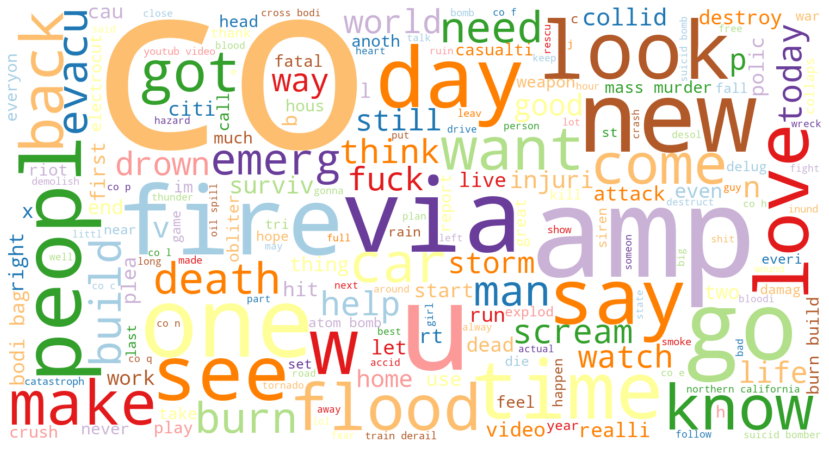

In [27]:
wordcloud = WordCloud(background_color = 'white', max_words = 200, width = 1500, height = 800, colormap = 'Paired').generate(''.join(corpus))

plt.figure(figsize = (32, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

One Hot representation
- Below code converts the pre-processed words to one-hot vectors in the range of vocabulary size = 5000. This is done to obtain numerical feature matrix.

In [28]:
voc_size = 5000

one_hot_rep = [one_hot(words, voc_size) for words in corpus] 
one_hot_rep[:5]

[[3006, 4545, 4342, 4030, 3829, 2042, 1880, 2805],
 [2945, 292, 3096, 2576, 1217, 4851, 3829, 2042, 434, 2067, 1169],
 [2034, 1287, 1665, 817, 2460, 2554, 4030, 1246, 3829, 2042, 3723],
 [3027, 2554, 4030],
 [3548, 3913, 1255, 4042, 2950, 4777, 4030, 3829, 2042, 3875, 1223]]

In [29]:
corpus[0]

'bbcmtd wholesal market ablaz http co lhyxeohi c'

In [30]:
one_hot_rep[0]

[3006, 4545, 4342, 4030, 3829, 2042, 1880, 2805]

In [31]:
len(one_hot_rep[0])

8

**Embedding Representation**

pad_sequences
- The pad_sequences() function in the Keras deep learning library can be used to pad variable length sequences. The default padding value is 0.0, which is suitable for most applications, although this can be changed by specifying the preferred value via the “value” argument.
- By this we are going to make all the sentances in same length.There are 2 types of padding, "Pre" and "Post", pre means it's going to add 0 in front and post means it's goint add 0 in back


In [32]:
sentence_length = 25
embedded_docs = pad_sequences(one_hot_rep, padding = 'pre', maxlen = sentence_length)
print(embedded_docs)

[[   0    0    0 ... 2042 1880 2805]
 [   0    0    0 ...  434 2067 1169]
 [   0    0    0 ... 3829 2042 3723]
 ...
 [   0    0    0 ... 3829 2042  991]
 [   0    0    0 ... 3829 2042  257]
 [   0    0    0 ... 2042 1223 3558]]


# **Creating Model**

In [33]:
embedding_vector_features = 40

In [34]:
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length = sentence_length))
model.add(Dropout(0.3))
model.add(LSTM(200))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 25, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 200)               192800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 393,001
Trainable params: 393,001
Non-trainable params: 0
_________________________________________________________________


In [35]:
z = np.array(embedded_docs)
y = np.array(y)

In [36]:
z.shape, y.shape

((7552, 25), (7552,))

**Splitting the training dataset**

In [37]:
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size = 0.33, random_state = 42)

**Training the model**

In [38]:
res = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20, batch_size = 32)

Epoch 1/20
159/159 [==============================] - 20s 101ms/step - loss: 0.5993 - accuracy: 0.6689 - val_loss: 0.4782 - val_accuracy: 0.7854
Epoch 2/20
159/159 [==============================] - 15s 92ms/step - loss: 0.3983 - accuracy: 0.8280 - val_loss: 0.4772 - val_accuracy: 0.7854
Epoch 3/20
159/159 [==============================] - 15s 95ms/step - loss: 0.3011 - accuracy: 0.8751 - val_loss: 0.5447 - val_accuracy: 0.7766
Epoch 4/20
159/159 [==============================] - 12s 74ms/step - loss: 0.2269 - accuracy: 0.9112 - val_loss: 0.6386 - val_accuracy: 0.7730
Epoch 5/20
159/159 [==============================] - 15s 93ms/step - loss: 0.1703 - accuracy: 0.9352 - val_loss: 0.7102 - val_accuracy: 0.7517
Epoch 6/20
159/159 [==============================] - 19s 122ms/step - loss: 0.1204 - accuracy: 0.9573 - val_loss: 0.9239 - val_accuracy: 0.7449
Epoch 7/20
159/159 [==============================] - 15s 94ms/step - loss: 0.0880 - accuracy: 0.9719 - val_loss: 0.9241 - val_accurac

In [39]:
def plot_learning_curve(history, epochs):
  epoch_range = range(1, epochs + 1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Val'], loc = 'upper left')
  plt.show()

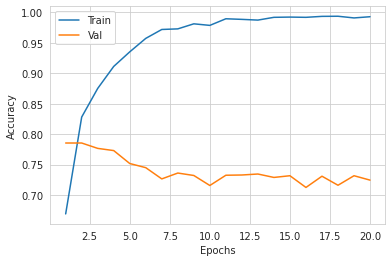

In [40]:
plot_learning_curve(res, 20)

**Importing test data**

In [41]:
test_df = pd.read_csv('/content/drive/MyDrive/disaster_nlp/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [53]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3263 non-null   object
dtypes: object(1)
memory usage: 25.6+ KB


In [42]:
print('Rows and columns in test dataset:', test_df.shape)

Rows and columns in test dataset: (3263, 4)


In [43]:
test_id = test_df['id'] 
test_df = test_df.drop(['id', 'keyword', 'location'], axis = 1) 
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


**Checking null values**

In [44]:
test_df.isnull().sum()

text    0
dtype: int64

**Data preprocessing test data**

In [45]:
ps = PorterStemmer() 
corpus_test = []
for i in range(0, len(test_df)):
  review = re.sub('[^a-zA-Z]', ' ', test_df['text'][i])
  review = review.lower()
  review = review.split()

  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus_test.append(review)

In [46]:
corpus_test[:5]

['happen terribl car crash',
 'heard earthquak differ citi stay safe everyon',
 'forest fire spot pond gees flee across street cannot save',
 'apocalyps light spokan wildfir',
 'typhoon soudelor kill china taiwan']

In [47]:
one_hot_rep_test = [one_hot(words, voc_size) for words in corpus_test]

**Embedding Representation**

In [48]:
sentence_length = 25

embedded_docs_test = pad_sequences(one_hot_rep_test, padding = 'pre', maxlen = sentence_length)
print(embedded_docs_test)

[[   0    0    0 ... 4292  446 3426]
 [   0    0    0 ... 3070 2859 1069]
 [   0    0    0 ... 4624 2909  167]
 ...
 [   0    0    0 ... 3829 2042 3303]
 [   0    0    0 ... 2042 2302 4384]
 [   0    0    0 ... 2999 2753 2593]]


In [49]:
x_test = np.array(embedded_docs_test) 
x_test

array([[   0,    0,    0, ..., 4292,  446, 3426],
       [   0,    0,    0, ..., 3070, 2859, 1069],
       [   0,    0,    0, ..., 4624, 2909,  167],
       ...,
       [   0,    0,    0, ..., 3829, 2042, 3303],
       [   0,    0,    0, ..., 2042, 2302, 4384],
       [   0,    0,    0, ..., 2999, 2753, 2593]], dtype=int32)

**Making predictions for the test dataset**

In [50]:
check = model.predict(x_test)
check = check.round()

In [51]:
val = []
for i in check:
  val.append(i[0])

submission = pd.DataFrame({'id': test_id, 'label': val})
submission.head()

,id,label
0,0,0.0
1,2,1.0
2,3,1.0
3,9,1.0
4,11,1.0
